## Load things

In [2]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import pandas as pd

import os,sys
# sys.addaudithook
rpath = os.getcwd()
sys.path.insert(0,"../")
# import utils

import dimred ### library of dimension reduction
from dimred.newpipe import RunnerTime

In [3]:
from ipywidgets import widgets
from ipywidgets import interactive,interact,interact_manual,interactive_output,interaction
from  ipywidgets.widgets import Tab,IntSlider,Dropdown,IntRangeSlider,VBox,HBox,HTML
from IPython.display import display

In [4]:
rn = RunnerTime()
species = rn.loader.varid

reading file autoignition.0.0000E+00.field.mpi...
Average Error is 0.0000


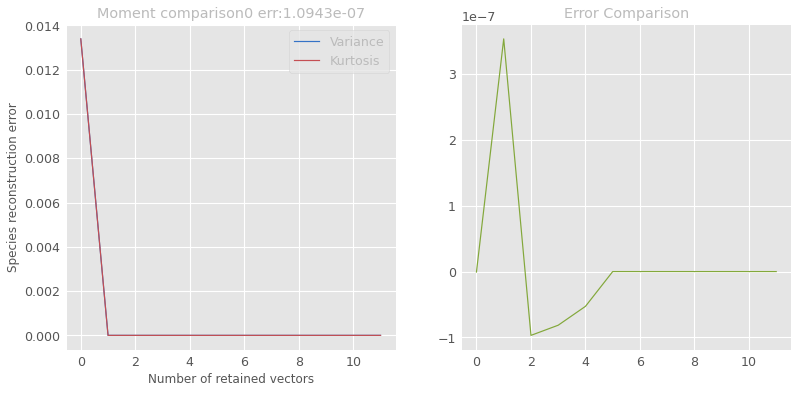

In [30]:
time_slier = IntSlider(value=100,
            min=0,
            max=200,
            step=1)
time_slier2 = IntSlider(value=100,min=0,max=200,step=1)
spec_select = Dropdown(options=species)

out1 = widgets.interactive_output(rn.mf_plot,{'time_step':time_slier,'spec':spec_select})
out2 = widgets.interactive_output(rn.mf_embed,{'time_step':time_slier2})

retain_slider = Dropdown(options=range(12))
time_slider3 = IntSlider(value=100,min=0,max=200,step=1)
out3 = widgets.interactive_output(rn.mf_build,{"time_index":time_slider3,'n_retain':retain_slider}) 


moms = Dropdown(options= rn.total.keys())
sources = Dropdown(options=rn.total['covariance']['old'].keys())
specs = Dropdown(options=species)
out4 = widgets.interactive_output(rn.mf_compare,{'moment':moms,'source':sources,'specs':specs})
out5 =  widgets.interactive_output(rn.mf_errors,{'source':sources})

slicer = Dropdown(options=range(201))
out6 = interactive_output(rn.mf_orient,{'time_step':slicer})
scales = Dropdown(options=['linear','log'])
out7 = interactive_output(rn.mf_retain,{'time_step':slicer,'scale':scales})

In [34]:

datatab = VBox(children=[
    time_slier,spec_select,
    out1
],title='Data')
embedtab= VBox(children=[
    time_slier2, out2])

midList = [time_slider3,retain_slider,out3,moms,sources,specs]
inigram = VBox(children=midList +[out4])
errgram = VBox(children=midList[:-3]+ [sources,out5])

orient = VBox(children=[slicer,out6,out7])

retain =VBox(children=[])
topbar = Tab(children=[datatab,embedtab,inigram,errgram,orient,retain])
titles = ['dataset','embedding','reconstr','species','vectors','xerox']

for i,name in enumerate(titles):
    topbar.set_title(i,name)


In [35]:
topbar

In [28]:
topbar

In [43]:
rn = RunnerTime()
rn.mf_build(100)

reading file autoignition.1.0000E-05.field.mpi...
co_variance reconstruction error after retaining 4 vectors is 1.108e-03
val kurtosis reconstruction error after retaining 4 vectors is 1.495e-03


In [45]:
inigram.children

(Dropdown(description='time_index', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200), value=0),
 Dropdown(description='n_retain', index=4, option

In [20]:
datae = interactive(rn.mf_plot,time_step=range(201),spec=rn.loader.varid)
embed = interactive(rn.mf_embed,time_step=range(201))
inigram =interactive(rn.mf_build,time_index=range(201),n_retain=range(12))
textile = interactive(rn.mf_compare,moment=rn.total.keys(),source=rn.total['covariance']['old'].keys(),specs=rn.loader.varid)
recon = VBox(children=[inigram,textile])
erons =  interactive(rn.mf_errors,source=rn.total['covariance']['old'].keys())

tablist = [datae,embed,recon,erons]
topbar = widgets.Tab(children=tablist)



In [22]:
# topbar

In [15]:
datae

interactive(children=(Dropdown(description='time_step', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,…

In [ ]:
embed

interactive(children=(Dropdown(description='time_step', index=100, options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, …

In [17]:
recon

In [18]:
erons

interactive(children=(Dropdown(description='source', options=('production', 'reaction', 'mass', 'hrr'), value=…

In [20]:

interactive(rn.mf_orient,time_step=range(201))

interactive(children=(Dropdown(description='time_step', index=100, options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, …

interactive(children=(Dropdown(description='time_step', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,…

In [12]:
rn.loader.varid

{'H2': 0,
 ' O2': 1,
 ' O': 2,
 ' OH': 3,
 ' H2O': 4,
 ' H': 5,
 ' HO2': 6,
 ' H2O2': 7,
 ' CO': 8,
 ' CO2': 9,
 ' HCO': 10,
 ' N2': 11,
 ' T': 12,
 ' P': 13,
 ' vx': 14,
 ' vy': 15,
 ' vz': 16}

In [13]:
rn.mf_alldata()

reading file autoignition.0.0000E+00.field.mpi...
co_variance reconstruction error after retaining 4 vectors is 1.637e-02
val kurtosis reconstruction error after retaining 4 vectors is 1.946e-02
reading file autoignition.1.0000E-07.field.mpi...
co_variance reconstruction error after retaining 4 vectors is 2.513e-03
val kurtosis reconstruction error after retaining 4 vectors is 2.881e-03
reading file autoignition.2.0000E-07.field.mpi...
co_variance reconstruction error after retaining 4 vectors is 2.303e-03
val kurtosis reconstruction error after retaining 4 vectors is 2.597e-03
reading file autoignition.3.0000E-07.field.mpi...
co_variance reconstruction error after retaining 4 vectors is 2.176e-03
val kurtosis reconstruction error after retaining 4 vectors is 2.389e-03
reading file autoignition.4.0000E-07.field.mpi...
co_variance reconstruction error after retaining 4 vectors is 2.060e-03
val kurtosis reconstruction error after retaining 4 vectors is 2.250e-03
reading file autoignition

In [14]:

itc(rn.mf_allerror,source=rn.total['covariance']['old'].keys(),spec=rn.loader.varid)
# plt.figure(figsize=(18,6))

interactive(children=(Dropdown(description='source', options=('production', 'reaction', 'mass', 'hrr'), value=…

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>(*args, **kwargs)>

In [16]:
import pickle

In [18]:
filer = open('err_val_kurtosis.pkl','wb')

In [19]:
with open(saver,'wb') as filer:
    pickle.dump(err_dict,filer)

Signature:
pickle.dump(
    obj,
    file,
    protocol=None,
    *,
    fix_imports=True,
    buffer_callback=None,
)
Docstring:
Write a pickled representation of obj to the open file object file.

This is equivalent to ``Pickler(file, protocol).dump(obj)``, but may
be more efficient.

The optional *protocol* argument tells the pickler to use the given
protocol; supported protocols are 0, 1, 2, 3, 4 and 5.  The default
protocol is 4. It was introduced in Python 3.4, and is incompatible
with previous versions.

Specifying a negative protocol version selects the highest protocol
version supported.  The higher the protocol used, the more recent the
version of Python needed to read the pickle produced.

The *file* argument must have a write() method that accepts a single
bytes argument.  It can thus be a file object opened for binary
writing, an io.BytesIO instance, or any other custom object that meets
this interface.

If *fix_imports* is True and protocol is less than 3, pickle will try

In [15]:
rn.loader.varid

{'H2': 0,
 ' O2': 1,
 ' O': 2,
 ' OH': 3,
 ' H2O': 4,
 ' H': 5,
 ' HO2': 6,
 ' H2O2': 7,
 ' CO': 8,
 ' CO2': 9,
 ' HCO': 10,
 ' N2': 11,
 ' T': 12,
 ' P': 13,
 ' vx': 14,
 ' vy': 15,
 ' vz': 16}